# Shelf break jet analysis along Oleander line

In [1]:
#Import import importants
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np 
import math
import matplotlib.font_manager
import cmocean as cmo
from tqdm import tqdm
import cartopy.crs as ccrs
import os
from matplotlib import colors
from matplotlib.animation import FuncAnimation 
import matplotlib.animation as animation
import xorca_brokenline as bl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from matplotlib import ticker
import pandas as pd
import scipy.odr
from scipy.stats import t, norm

#Ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

#Local path to respository (Change to your directory for code to work)
path_rp = '/home/milon.miah/Documents/'

#Import functions from classes calc and util
os.chdir(path_rp + 'DV_NAshelf_NEMO/Scripts')
from worldmap import WorldMap
from calc import *
from util import *
os.chdir(path_rp)

#Plot parameters
plt.rcParams['font.size'] = 20.0

## Load section data

In [2]:
#Load Oleander data
path_sections = '/vortex/clidex/data/NEMO/VIKING20X/sections/section_'
ds_OL = xr.open_dataset(path_sections + 'Oleander_incl_GS.nc')

#Cut off land mass
ds_OL = ds_OL.where(ds_OL != 0.0)

#Cut off depth optionally
depth = None
if depth != None:
    ds_OL = ds_OL.sel(z = slice(0, depth))

In [3]:
#Create some useful lists
prop = ['votemper', 'vosaline',  'u_rot_along', 'u_rot_normal']
titles = ['Temperature', 'Salinity', 'Velocity along', 'Velocity normal']
units = [' [°C]', ' [g/kg]', ' [m/s]', ' [m/s]']
cmap = ['cmo.thermal', 'cmo.haline', 'cmo.balance', 'cmo.balance']
time_periods = ['1960', '1968', '1986', '2012']
interval = [[1150, 1350], [350, 930]] #GS, SBJ positions (for later)

## Plot overview map

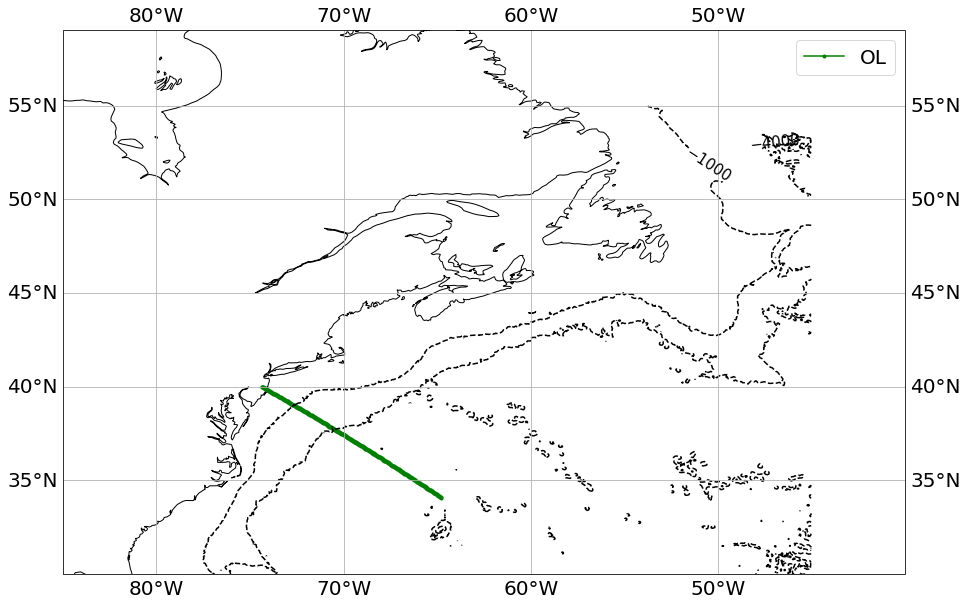

In [4]:
#Create Figure
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

#Create WorldMap from implemented module
atl = WorldMap(real_color = False, zoom = [-85, -40, 30, 57], ax = ax)

#Plot sections
atl.Ax.plot(ds_OL.lon, ds_OL.lat, color = 'g', marker = '.', ls = None, label ='OL')

#Add bathymetry 
bthy1 = atl.add_bathymetry(-1000)
bthy2 = atl.add_bathymetry(-4000)
plt.legend()

#Save figure
fig.savefig(path_rp + 'DV_NAshelf_NEMO/Plots/Maps/sections_OL.png')

## Plot time-mean field

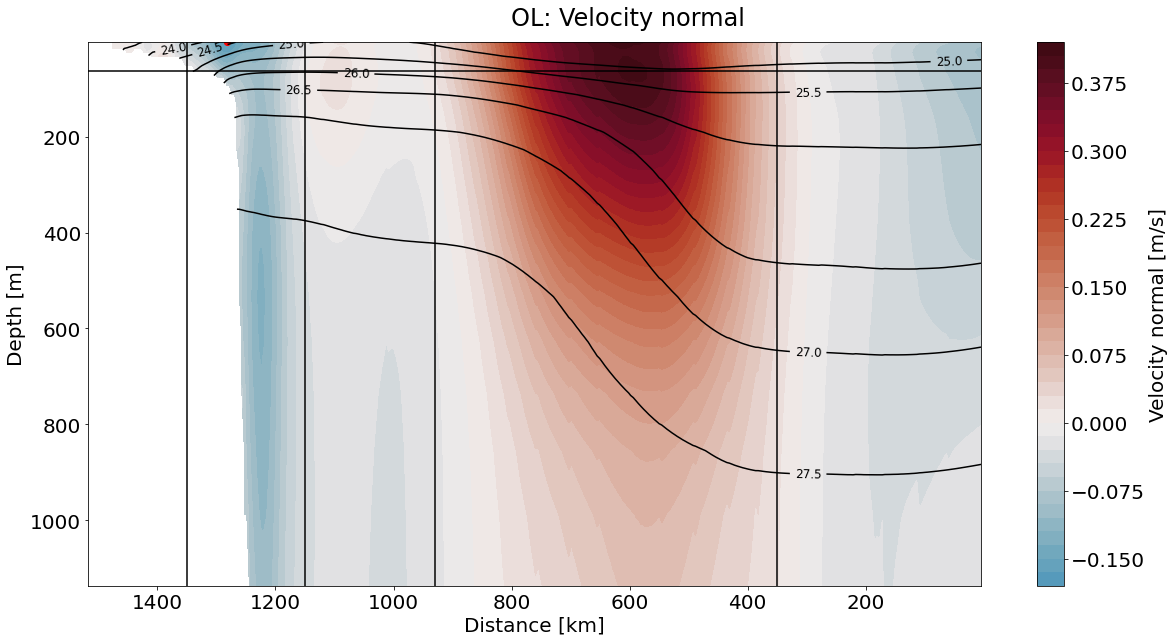

In [5]:
%matplotlib inline
plt.rcParams['font.size'] = 20.0

#Compute time mean field
ds_OL_sbj_mean = ds_OL.sel(time_counter = slice('16-01-1958', '16-01-2018')).mean(dim = 'time_counter')

#Create figure
fig, ax = plt.subplots(figsize = (20,10))
fig.suptitle('OL: Velocity normal', y = 0.93)
cmap = 'cmo.balance'

#Create colormesh and make sure velocity colorbars are normalized
cmesh = ax.contourf(ds_OL_sbj_mean.c/1e3, ds_OL_sbj_mean.z, ds_OL_sbj_mean['u_rot_normal'], cmap = cmap, levels = 50,
                    norm = colors.CenteredNorm())
fig.colorbar(cmesh, ax = ax, label = 'Velocity normal [m/s]', location = 'right')

#Add density contour lines
vertical_append(levels = 10, sec = ds_OL_sbj_mean, axh = ax)

#Invert axes
ax.invert_yaxis()
ax.invert_xaxis()

ax.set_xlabel('Distance [km]')
ax.set_ylabel('Depth [m]')

#Plot vertical lines for chosen intervals
ax.axvline(x = interval[0][0], color = 'black')
ax.axvline(x = interval[0][1], color = 'black')
ax.axvline(x = interval[1][0], color = 'black')
ax.axvline(x = interval[1][1], color = 'black')

#Find global minimum in time mean field
sbj_min = float(ds_OL_sbj_mean['u_rot_normal'].min().to_numpy())
sbj_pos = np.where(ds_OL_sbj_mean['u_rot_normal'] == sbj_min)

#Investigate gradient (not used anymore later)
grad = (sbj_min - ds_OL_sbj_mean.sel(c = ds_OL_sbj_mean['c'][sbj_pos[1]], z = ds_OL_sbj_mean['z'][7])['u_rot_normal']).to_numpy()[0]
ax.axhline(y = ds_OL_sbj_mean['z'][7], color = 'black')
ax.scatter(ds_OL_sbj_mean.c[sbj_pos[1]]/1e3, ds_OL_sbj_mean.z[sbj_pos[0]], color = 'red')

#Save figure
fig.savefig(path_rp + 'DV_NAshelf_NEMO/Plots/Oleander/time_mean_OL.png')

## Yearly averages
### Animation of detecting SBJ

<IPython.core.display.Javascript object>


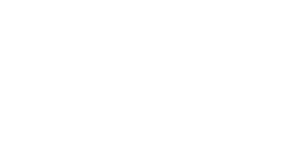

In [6]:
%matplotlib notebook
plt.rcParams['font.size'] = 10.0

#Select data corresponding zu maximal interval
ds_OL_sbj = ds_OL.sel(c = slice(interval[0][0]*1e3, interval[0][1]*1e3))

#Group data by years
ds_OL_sbj_gr = ds_OL_sbj.groupby('time_counter.year').mean(dim = 'time_counter')

#Creating figures
fig, ax = plt.subplots(figsize = (10,5))

#Define observation period and displayed depth
time_begin = '1958'
time_end = '2019'
z = 600

#Select data from time period
ds_OL_sbj_gr = ds_OL_sbj_gr.sel(year = slice(time_begin, time_end))

def animate(i):
    
    ax.clear()
    cmesh = ax.contourf(ds_OL_sbj_gr.c/1e3, ds_OL_sbj_gr.sel(z = slice(0,z)).z, ds_OL_sbj_gr.sel(z = slice(0,z))['u_rot_normal'][i], 
                    cmap = cmap, levels = 50, norm = colors.CenteredNorm())
    
    #Find minimum in scope
    sbj_min_year = float(ds_OL_sbj_gr['u_rot_normal'][i].min().to_numpy())
    
    #First criteria velocity greater than 0.10 m/s (ca. half of time-mean maximum, when SBJ present)
    if sbj_min_year < -0.10:
        
        sbj_pos = np.where(ds_OL_sbj_gr['u_rot_normal'][i] == ds_OL_sbj_gr['u_rot_normal'][i].min())
        
        #Second criteria, SBJ no deeper than 100 meter
        if ds_OL_sbj_gr.z[sbj_pos[0][0]] < 50:
            sbj_m100 = ds_OL_sbj_gr.sel(c = ds_OL_sbj_gr['c'][sbj_pos[1]],
                                        z = ds_OL_sbj_gr['z'][18])['u_rot_normal'][i].to_numpy()[0]
            
            #Third criteria existent gradient down to 100 meter to distinguish between barotropic Slope Jet
            #If distance between minimum and shelf is less than 100 meter, criteria is assumed to be fulfilled
            if np.isnan(sbj_m100):
                ax.scatter(ds_OL_sbj_gr.c[sbj_pos[1]]/1e3, ds_OL_sbj_gr.z[sbj_pos[0]], color = 'red', marker = 'x')
            
            else:
                grad_year = abs(sbj_min_year) - abs(sbj_m100)
                if grad_year > 0.1:
                    ax.scatter(ds_OL_sbj_gr.c[sbj_pos[1]]/1e3, ds_OL_sbj_gr.z[sbj_pos[0]], color = 'red', marker = 'x')

    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_title('OL: ' + '{}'.format(ds_OL_sbj_gr['year'][i].to_numpy()))
    ax.set_xlabel('Distance [m]')
    ax.set_ylabel('Depth [m]')

cbar = fig.colorbar(cmesh, ax = ax, location = 'right', label = 'Velocity normal [m/s]', pad = 0.1)
anim = FuncAnimation(fig, animate, frames = len(ds_OL_sbj_gr.year.to_numpy()), interval = 1000, blit = False)
writergif = animation.PillowWriter(fps=1)
anim.save(path_rp + 'DV_NAshelf_NEMO/Plots/Oleander/sbj_position_OL_yearly.gif', writer=writergif)



### Collect data of SBJ detection

In 77.4 % of the years the shelf break jet is present.


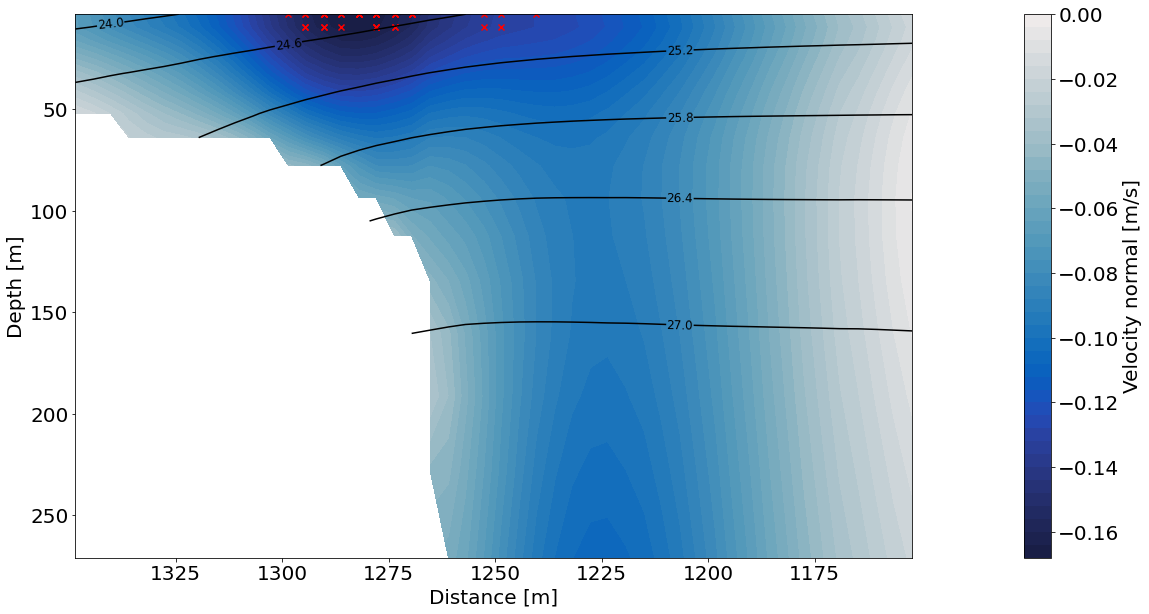

In [7]:
%matplotlib inline
plt.rcParams['font.size'] = 20.0

#Select data corresponding zu maximal interval
ds_OL_sbj = ds_OL.sel(c = slice(interval[0][0]*1e3, interval[0][1]*1e3))

#Group data by yearly averages
ds_OL_sbj_gr = ds_OL_sbj.groupby('time_counter.year').mean(dim = 'time_counter')

#Create colormesh with time-mean field as reference
fig, ax = plt.subplots(figsize = (20,10))
cmesh = ax.contourf(ds_OL_sbj_mean.sel(c = slice(interval[0][0]*1e3, interval[0][1]*1e3), z= slice(0,300)).c/1e3,
                ds_OL_sbj_mean.sel(c = slice(interval[0][0]*1e3, interval[0][1]*1e3), z= slice(0,300)).z,
                ds_OL_sbj_mean.sel(c = slice(interval[0][0]*1e3, interval[0][1]*1e3), z= slice(0,300))['u_rot_normal'],
                cmap = 'cmo.balance', levels = 50, norm = colors.CenteredNorm())

#Add density lines
vertical_append(levels = 6, sec = ds_OL_sbj_mean.sel(c = slice(interval[0][0]*1e3, interval[0][1]*1e3), z= slice(0,300)), axh = ax)

#Collect data of minimum in list
sbj_min = []
sbj_year = []
sbj_pos = []
for i in range(len(ds_OL_sbj_gr['year'])):
    
    #Find minimum in scope
    sbj_min_year = float(ds_OL_sbj_gr['u_rot_normal'][i].min().to_numpy())
    
    #First criteria velocity greater than 0.10 m/s (ca. half of time-mean maximum, when SBJ present)
    if sbj_min_year < -0.10:
        
        sbj_pos_year = np.where(ds_OL_sbj_gr['u_rot_normal'][i] == ds_OL_sbj_gr['u_rot_normal'][i].min())
        
        #Second criteria, SBJ no deeper than 100 meter
        if ds_OL_sbj_gr.z[sbj_pos_year[0][0]] < 50:
            sbj_m100 = ds_OL_sbj_gr.sel(c = ds_OL_sbj_gr['c'][sbj_pos_year[1]],
                                        z = ds_OL_sbj_gr['z'][18])['u_rot_normal'][i].to_numpy()[0]
            
            #Third criteria existent gradient down to 100 meter to distinguish between barotropic Slope Jet
            #If distance between minimum and shelf is less than 100 meter, criteria is assumed to be fulfilled
            if np.isnan(sbj_m100):
                ax.scatter(ds_OL_sbj_gr.c[sbj_pos_year[1]]/1e3, ds_OL_sbj_gr.z[sbj_pos_year[0]], color = 'red', marker = 'x')
                sbj_min.append(abs(sbj_min_year))
                sbj_year.append(int(ds_OL_sbj_gr['year'][i].to_numpy()))
                sbj_pos.append(sbj_pos_year)
            else:
                grad_year = abs(sbj_min_year) - abs(sbj_m100)
                if grad_year > 0.1:
                    ax.scatter(ds_OL_sbj_gr.c[sbj_pos_year[1]]/1e3, ds_OL_sbj_gr.z[sbj_pos_year[0]], color = 'red', marker = 'x')
                    sbj_min.append(abs(sbj_min_year))
                    sbj_year.append(int(ds_OL_sbj_gr['year'][i].to_numpy()))
                    sbj_pos.append(sbj_pos_year)
        
cbar = fig.colorbar(cmesh, ax = ax, location = 'right', label = 'Velocity normal [m/s]', pad = 0.1)
            
ax.invert_xaxis()
ax.invert_yaxis()

ax.set_xlabel('Distance [m]')
ax.set_ylabel('Depth [m]')

#Create Dataset with SBJ strength time series
sbj_yearly = xr.Dataset(data_vars = dict(sbj_vel = (['time_counter'], sbj_min)), coords = dict(time_counter = sbj_year))

#Compute percentage of SBJ's presence
sbj_there = len(sbj_pos)/len(ds_OL_sbj_gr['year'])
print('In {:.1f} % of the years the shelf break jet is present.'.format(sbj_there*100))

#Save figure
fig.savefig(path_rp + 'DV_NAshelf_NEMO/Plots/Oleander/detected_SBJ_yearly.png')

### Histogram of SBJ position of yearly data

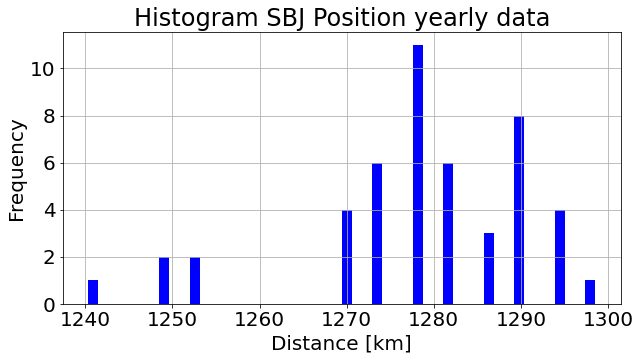

In [8]:
%matplotlib inline
plt.rcParams['font.size'] = 20.0

#Save positions of SBJ
fig, ax = plt.subplots(figsize = (10,5))
sbj_c = []
sbj_pos = np.array(sbj_pos)
for i in range(len(sbj_pos[:,1])):
    sbj_c.append(ds_OL_sbj_gr.c[sbj_pos[i][1]].to_numpy()[0]/1e3)

#Create histrogram
ax.hist(sbj_c, bins = 50, color = 'blue')
ax.grid()
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Frequency')
ax.set_title('Histogram SBJ Position yearly data')

#Save figure
fig.savefig(path_rp + 'DV_NAshelf_NEMO/Plots/Oleander/hist_SBJ_yearly.png')

### Time series 

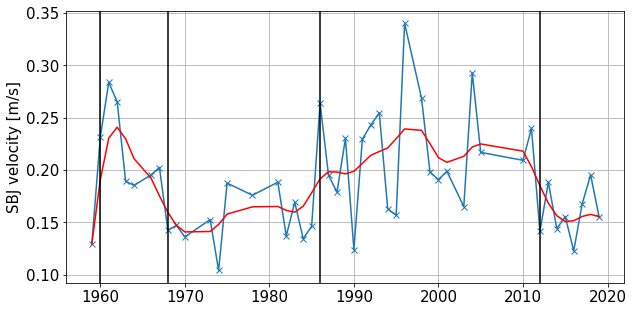

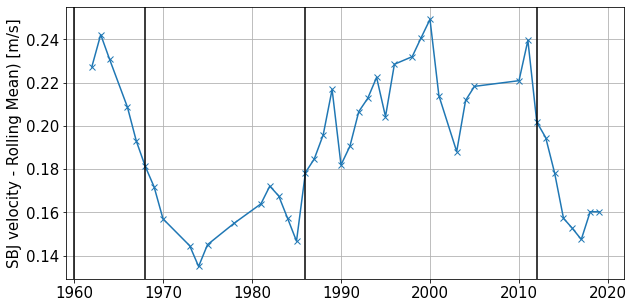

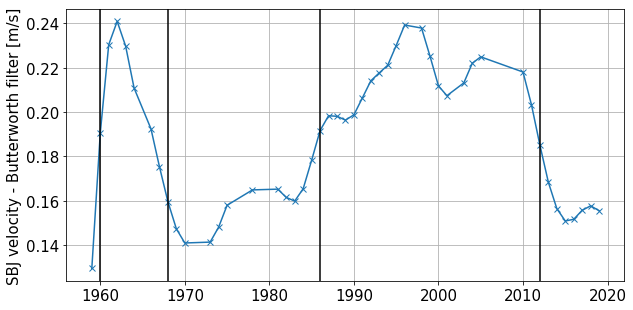

In [9]:
%matplotlib inline
plt.rcParams['font.size'] = 20.0

#Plot time series of SBJ strength
plt.rcParams['font.size'] = 15.0
time_periods = [1960, 1968, 1986, 2012]

#Computer filtered data
sbj_min_roll = sbj_yearly.rolling(time_counter = 4).mean(dim = 'time_counter')
sbj_min_butt = butterworth_lowpass_filter(sbj_min, order = 2, cutoff_freq = 1/4)

#Plot time series of SBJ strength
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(sbj_year, sbj_yearly.sbj_vel, marker = 'x')
ax.grid()
ax.set_ylabel('SBJ velocity [m/s]')
ax.plot(sbj_year, sbj_min_butt, color = 'r')

for i in range(len(time_periods)):
    ax.axvline(time_periods[i], color = 'black')

# Take running mean of data
fig_r, ax_r = plt.subplots(figsize = (10, 5))           
ax_r.plot(sbj_year, sbj_min_roll.sbj_vel, marker = 'x')
ax_r.grid()
ax_r.set_ylabel('SBJ velocity - Rolling Mean) [m/s]')

for i in range(len(time_periods)):
    ax_r.axvline(time_periods[i], color = 'black')

#Apply Butterworth filter
fig_b, ax_b = plt.subplots(figsize = (10, 5))          
ax_b.plot(sbj_year, sbj_min_butt, marker = 'x')
ax_b.grid()
ax_b.set_ylabel('SBJ velocity - Butterworth filter [m/s]')

for i in range(len(time_periods)):
    ax_b.axvline(time_periods[i], color = 'black')
    
#Save figures
fig.savefig(path_rp + 'DV_NAshelf_NEMO/Plots/Oleander/SBJ_timeseries_yearly.png')
fig_r.savefig(path_rp + 'DV_NAshelf_NEMO/Plots/Oleander/SBJ_timeseries_runmean_yearly.png')
fig_b.savefig(path_rp + 'DV_NAshelf_NEMO/Plots/Oleander/SBJ_timeseries_bworth_yearly.png')


## Monthly data
### Animation

<IPython.core.display.Javascript object>


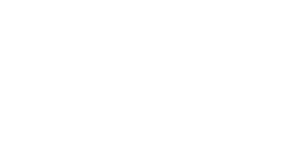

In [10]:
%matplotlib notebook
plt.rcParams['font.size'] = 15.0

#Creating figures
fig, ax = plt.subplots(figsize = (10,5))

#Define observation period and z interval to be observed 
time_begin = '16-01-1958'
time_end = '16-12-2018'
z = 600

#Select data from time period
ds_OL_sbj = ds_OL_sbj.sel(time_counter = slice(time_begin, time_end))

#Add initial colormesh
cmesh = ax.contourf(ds_OL_sbj.sel(z = slice(0,z)).c/1e3, ds_OL_sbj.sel(z = slice(0,z)).z, ds_OL_sbj.sel(z = slice(0,z))['u_rot_normal'][0], 
                    cmap = cmap, levels = 50, norm = colors.CenteredNorm())
cbar = fig.colorbar(cmesh, ax = ax, location = 'right', label = 'Velocity normal [m/s]', pad = 0.1)
ax.set_xlabel('Distance [m]')
ax.set_ylabel('Depth [m]')

def animate(i):
       
    ax.clear()
    cmesh = ax.contourf(ds_OL_sbj.sel(z = slice(0,z)).c/1e3, ds_OL_sbj.sel(z = slice(0,z)).z, ds_OL_sbj.sel(z = slice(0,z))['u_rot_normal'][i], 
                        cmap = cmap, levels = 50, norm = colors.CenteredNorm())
    
    #Find minimum in scope
    sbj_min_month = float(ds_OL_sbj['u_rot_normal'][i].min().to_numpy())
    
    #First criteria velocity greater than 0.10 m/s (ca. half of time-mean maximum, when SBJ present)
    if sbj_min_month < -0.10:
        sbj_pos_month = np.where(ds_OL_sbj['u_rot_normal'][i] == ds_OL_sbj['u_rot_normal'][i].min())
        
        #Second criteria, SBJ no deeper than 50 meters and optionally further enclosing of SBJ in distance from shelf 
        if ds_OL_sbj.z[sbj_pos_month[0][0]] < 50:# and 1330*1e3 > ds_OL_sbj.c[sbj_pos_month[1][0]] > 1220*1e3:
            
            #Third criteria existent gradient down to 100 meter to distinguish between barotropic Slope Jet
            #If distance between minimum and shelf is less than 100 meter, criteria is assumed to be fulfilled
            sbj_m100 = ds_OL_sbj.sel(c = ds_OL_sbj['c'][sbj_pos_month[1]],
                                     z = ds_OL_sbj['z'][18])['u_rot_normal'][i].to_numpy()[0]
            if np.isnan(sbj_m100):
                ax.scatter(ds_OL_sbj.c[sbj_pos_month[1]]/1e3, ds_OL_sbj.z[sbj_pos_month[0]], color = 'red', marker = 'x')
            else:
                grad_month = abs(sbj_min_month) - abs(sbj_m100)
                if grad_month > 0.1:
                    ax.scatter(ds_OL_sbj.c[sbj_pos_month[1]]/1e3, ds_OL_sbj.z[sbj_pos_month[0]], color = 'red', marker = 'x')
                    
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_title('OL: ' + np.datetime_as_string(ds_OL_sbj['time_counter'][i].to_numpy(), unit = 'M'))
    ax.set_xlabel('Distance [m]')
    ax.set_ylabel('Depth [m]')

anim = FuncAnimation(fig, animate, frames = len(ds_OL_sbj.time_counter.to_numpy()), interval = 1000, blit = True)
writergif = animation.PillowWriter(fps=1)
anim.save(path_rp + 'DV_NAshelf_NEMO/Plots/Oleander/sbj_position_OL.gif', writer=writergif)

### Collect data of SBJ detection

In 69.1 % of the cases the shelf break jet is present


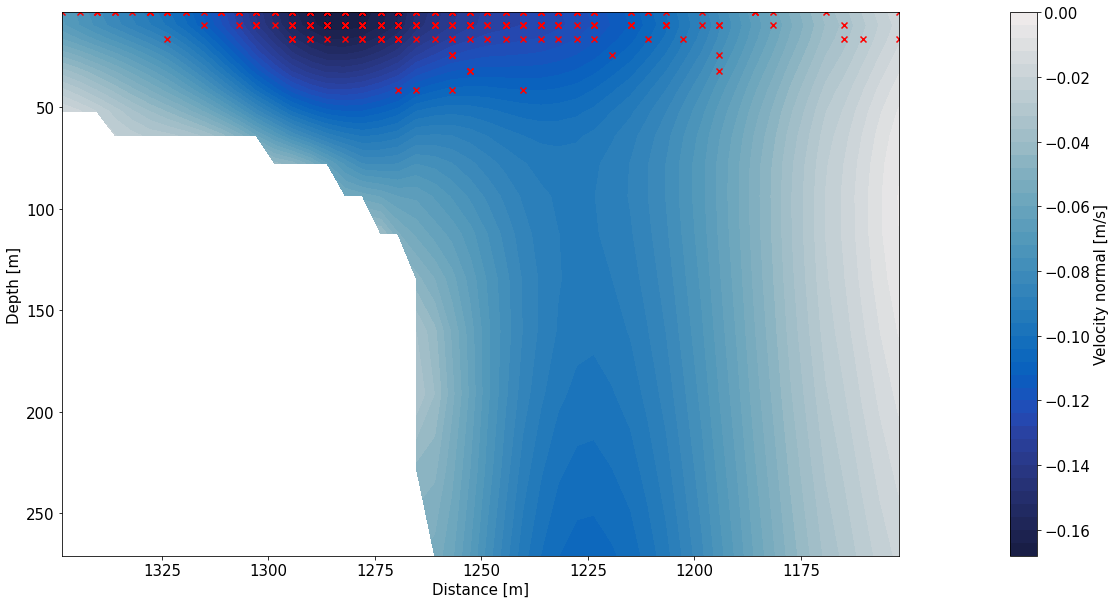

In [11]:
%matplotlib inline
plt.rcParams['font.size'] = 15.0

fig, ax = plt.subplots(figsize = (20,10))

cmesh = ax.contourf(ds_OL_sbj_mean.sel(c = slice(interval[0][0]*1e3, interval[0][1]*1e3), z = slice(0,300)).c/1e3,
                ds_OL_sbj_mean.sel(c = slice(interval[0][0]*1e3, interval[0][1]*1e3), z = slice(0,300)).z,
                ds_OL_sbj_mean.sel(c = slice(interval[0][0]*1e3, interval[0][1]*1e3), z = slice(0,300))['u_rot_normal'],
                cmap = 'cmo.balance', levels = 50, norm = colors.CenteredNorm())

sbj_time_counter= []
sbj_min = []
sbj_pos = []
for i in range(len(ds_OL_sbj['time_counter'])):
    
    #Find minimum in scope
    sbj_min_month = float(ds_OL_sbj['u_rot_normal'][i].min().to_numpy())
    
    #First criteria velocity greater than 0.10 m/s (ca. half of time-mean maximum, when SBJ present) and optionally cut off high velocities (probably more slope jet)
    if sbj_min_month < -0.10:# and sbj_min_month > -0.47:
        sbj_pos_month = np.where(ds_OL_sbj['u_rot_normal'][i] == ds_OL_sbj['u_rot_normal'][i].min())
        
        #Second criteria, SBJ no deeper than 50 meters and optionally further enclosing of SBJ in distance from shelf 
        if ds_OL_sbj.z[sbj_pos_month[0][0]] < 50:# and 1330*1e3 > ds_OL_sbj.c[sbj_pos[1][0]] > 1220*1e3:
            
            #Third criteria existent gradient down to 100 meter to distinguish between barotropic Slope Jet
            #If distance between minimum and shelf is less than 100 meter, criteria is assumed to be fulfilled
            sbj_m100 = ds_OL_sbj.sel(c = ds_OL_sbj['c'][sbj_pos_month[1]], z = ds_OL_sbj['z'][18])['u_rot_normal'][i].to_numpy()[0]
            if np.isnan(sbj_m100):
                ax.scatter(ds_OL_sbj.c[sbj_pos_month[1]]/1e3, ds_OL_sbj.z[sbj_pos_month[0]], color = 'red', marker = 'x')
                sbj_time_counter.append(ds_OL_sbj['time_counter'][i].to_numpy())
                sbj_min.append(abs(sbj_min_month))
                sbj_pos.append(sbj_pos_month)
            else:
                grad_month = abs(sbj_min_month) - abs(sbj_m100)
                if grad_month > 0.1:
                    ax.scatter(ds_OL_sbj.c[sbj_pos_month[1]]/1e3, ds_OL_sbj.z[sbj_pos_month[0]], color = 'red', marker = 'x')
                    sbj_time_counter.append(ds_OL_sbj['time_counter'][i].to_numpy())
                    sbj_min.append(abs(sbj_min_month))
                    sbj_pos.append(sbj_pos_month)
            
cbar = fig.colorbar(cmesh, ax = ax, location = 'right', label = 'Velocity normal [m/s]', pad = 0.1)
            
ax.invert_xaxis()
ax.invert_yaxis()

ax.set_xlabel('Distance [m]')
ax.set_ylabel('Depth [m]')

#Create Dataset with SBJ strength time series
sbj_monthly = xr.Dataset(data_vars = dict(sbj_vel = (['time_counter'], sbj_min)), coords = dict(time_counter = sbj_time_counter))

#Compute percentage of SBJ's presence
sbj_there = len(sbj_min)/len(ds_OL_sbj['time_counter'])
print('In {:.1f} % of the cases the shelf break jet is present'.format(sbj_there*100))

#Save figure
fig.savefig(path_rp + 'DV_NAshelf_NEMO/Plots/Oleander/detected_SBJ_monthly.png')

### Histogram of SBJ position

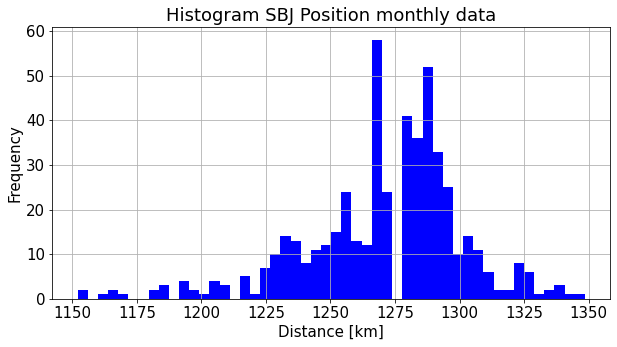

In [12]:
%matplotlib inline
plt.rcParams['font.size'] = 15.0

#Save positions of SBJ
fig, ax = plt.subplots(figsize = (10,5))
sbj_c = []
sbj_pos = np.array(sbj_pos)
for i in range(len(sbj_pos[:,1])):
    sbj_c.append(ds_OL_sbj.c[sbj_pos[i][1]].to_numpy()[0]/1e3)

ax.hist(sbj_c, bins = 50, color = 'blue')
ax.grid()
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Frequency')
ax.set_title('Histogram SBJ Position monthly data')

#Save figure
fig.savefig(path_rp + 'DV_NAshelf_NEMO/Plots/Oleander/hist_SBJ_monthly.png')

### Time series

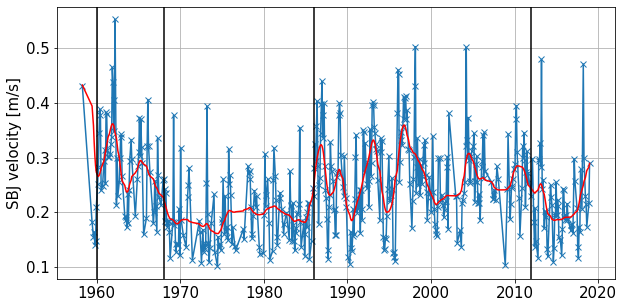

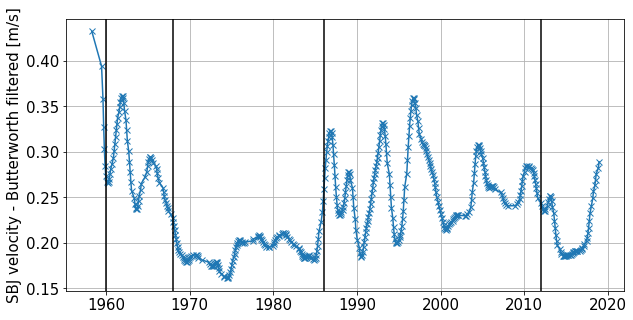

In [13]:
plt.rcParams['font.size'] = 15.0
time_periods = ['1960', '1968', '1986', '2012']

#Find indexes where SBJ values are available
idx = np.isfinite(sbj_monthly.sbj_vel)

#Apply Butterworth low-pass filter
sbj_min_butt = butterworth_lowpass_filter(sbj_monthly.sbj_vel[idx], order = 2, cutoff_freq = 1/12)

#Plot time series of SBJ strength
fig, ax = plt.subplots(figsize = (10,5))

ax.plot(sbj_monthly.time_counter[idx], sbj_monthly.sbj_vel[idx], marker = "x")
ax.grid()
ax.set_ylabel('SBJ velocity [m/s]')

#Add low pass filter in data
ax.plot(sbj_monthly.time_counter[idx], sbj_min_butt, color = 'r')

for i in range(len(time_periods)):
    ax.axvline(time_periods[i], color = 'black')

#Plot low-pass filtered time series
fig_b, ax_b = plt.subplots(figsize = (10,5))
            
ax_b.plot(sbj_monthly.time_counter[idx], sbj_min_butt, marker = 'x')
ax_b.grid()
ax_b.set_ylabel('SBJ velocity - Butterworth filtered [m/s]')

#Add vertical time period lines
for i in range(len(time_periods)):
    ax_b.axvline(time_periods[i], color = 'black')

#Save figures
fig.savefig(path_rp + 'DV_NAshelf_NEMO/Plots/Oleander/SBJ_timeseries_monthly.png')
fig_b.savefig(path_rp + 'DV_NAshelf_NEMO/Plots/Oleander/SBJ_timeseries_bworth_monthly.png')

### Linear regression as comparison to observations

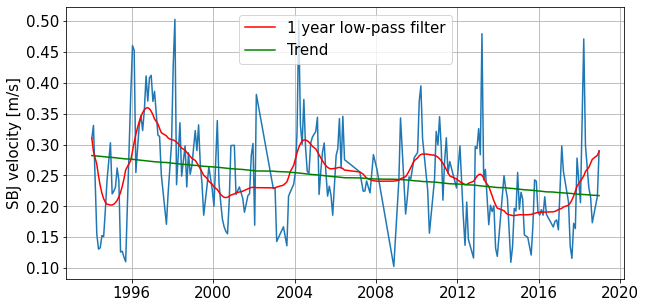

In [14]:
#Linear regression with recent data
#Adjusted time scale
time_lr = sbj_monthly.sel(time_counter = slice('16-01-1994', '16-01-2019')).time_counter
sbj_vel_lr = sbj_monthly.sel(time_counter = slice('16-01-1994', '16-01-2019')).sbj_vel

#Convert time format into numerical indices
time_index = np.arange(0, len(time_lr), 1)
time_index = np.where(np.isnan(sbj_vel_lr), np.nan, time_index)

#Cancel out index of given time period
idx_period = np.isfinite(time_index)

#Carry out actual least squares regression
p, var = np.polyfit(time_index[idx_period], sbj_vel_lr[idx_period], deg = 1, cov = True)

fig_period, ax_period = plt.subplots(figsize = (10,5))
sbj_min_butt_period = butterworth_lowpass_filter(sbj_vel_lr[idx_period], order = 2, cutoff_freq = 1/12)
ax_period.plot(time_lr[idx_period], sbj_vel_lr[idx_period])
ax_period.plot(time_lr[idx_period], sbj_min_butt_period, color = 'r', label = '1 year low-pass filter')
ax_period.grid()
ax_period.set_ylabel('SBJ velocity [m/s]')
ax_period.plot(time_lr[idx_period], p[0]*time_index[idx_period]+p[1], color = 'green', label = 'Trend')
ax_period.legend()

#Save figures
fig_period.savefig(path_rp + 'DV_NAshelf_NEMO/Plots/Oleander/sbj_forsyth_period.png')

### Test for significance of recent slope

In [15]:
#t test
#critical value
t_critical = -p[0]/np.sqrt(var[0][0])

#Degrees of freedom
df = len(time_index[idx_period]) - 2

#t statistics (right side one-sample test)
t_stat = 1 - t.cdf(t_critical, df)


#gaussian statistics (right side one-sample test) (expexted to be equivalent because of high number of freedom)
g_stat = 1 - norm.cdf(0, loc = p[0], scale = np.sqrt(var[0][0]))

print('The slope is negative with a significance level of t_stat = {:.5f} and/or g_stat = {:.6f}'.format(t_stat, g_stat))

The slope is negative with a significance level of t_stat = 0.00023 and/or g_stat = 0.000184


### Decrease of velocity 1994-2018

In [16]:
sbj_vel_decrease = p[0]*time_index[idx_period][0]+p[1]-(p[0]*time_index[idx_period][-1]+p[1])

print('The decrease of the velocity of the SBJ from 1994-2018 is {:.3f} m/s'.format(sbj_vel_decrease))

The decrease of the velocity of the SBJ from 1994-2018 is 0.065 m/s
